In [ ]:
!pip install kagglehub scikit-image tifffile


In [ ]:
!pip install imagecodecs


In [ ]:
import kagglehub
import os

# Download dataset
dataset_path = kagglehub.dataset_download("andrewmvd/drive-digital-retinal-images-for-vessel-extraction")

print("Dataset downloaded to:", dataset_path)

# Explore structure
for root, dirs, files in os.walk(dataset_path):
    print(root, "->", len(files), "files")


Using Colab cache for faster access to the 'drive-digital-retinal-images-for-vessel-extraction' dataset.
Dataset downloaded to: /kaggle/input/drive-digital-retinal-images-for-vessel-extraction
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction -> 0 files
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE -> 0 files
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training -> 0 files
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images -> 20 files
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/1st_manual -> 20 files
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/mask -> 20 files
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test -> 0 files
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test/images -> 20 files
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test/m

In [ ]:
import os
import glob
from skimage import io

# KaggleHub DRIVE root contains DRIVE folder
drive_root = os.path.join(dataset_path, "DRIVE")

img_dir = os.path.join(drive_root, "training", "images")
gt_dir  = os.path.join(drive_root, "training", "1st_manual")

img_paths = sorted(glob.glob(img_dir + "/*.tif"))
gt_paths  = sorted(glob.glob(gt_dir + "/*.gif"))

print("Images found:", len(img_paths))
print("GT masks found:", len(gt_paths))

# Safe test read
sample = io.imread(img_paths[0])
print("Sample shape:", sample.shape)


Images found: 20
GT masks found: 20
Sample shape: (584, 565, 3)


In [ ]:
import numpy as np
from skimage.filters import threshold_niblack, threshold_sauvola

# Extract green channel and normalize
def preprocess_green(img):
    green = img[:, :, 1].astype(np.float32)
    green = (green - green.min()) / (green.max() - green.min() + 1e-8)
    return green

# Niblack segmentation
def segment_niblack(green):
    th = threshold_niblack(green, window_size=25, k=-0.1)
    return (green < th).astype(np.uint8)

# Sauvola segmentation
def segment_sauvola(green):
    th = threshold_sauvola(green, window_size=25, k=0.05)
    return (green < th).astype(np.uint8)



In [ ]:
def sensitivity(pred, gt): # Computes sensitivity
    pred = pred.astype(bool)
    gt   = gt.astype(bool)

    TP = np.logical_and(pred, gt).sum()
    FN = np.logical_and(~pred, gt).sum()

    return TP / (TP + FN + 1e-8)


In [ ]:
from skimage import io

niblack_scores = []
sauvola_scores = []

for img_p, gt_p in zip(img_paths, gt_paths):
    img = io.imread(img_p)      # fundus image
    gt  = io.imread(gt_p)       # manual vessel mask

    # GT binarize
    gt = (gt > 0).astype(np.uint8)

    # Preprocess
    green = preprocess_green(img)

    # Segment
    niblack = segment_niblack(green)
    sauvola = segment_sauvola(green)

    # Evaluate
    niblack_scores.append(sensitivity(niblack, gt))
    sauvola_scores.append(sensitivity(sauvola, gt))

print("Average Sensitivity")
print("Niblack :", np.mean(niblack_scores))
print("Sauvola :", np.mean(sauvola_scores))


Average Sensitivity
Niblack : 0.8784368240825918
Sauvola : 0.6669945669429345


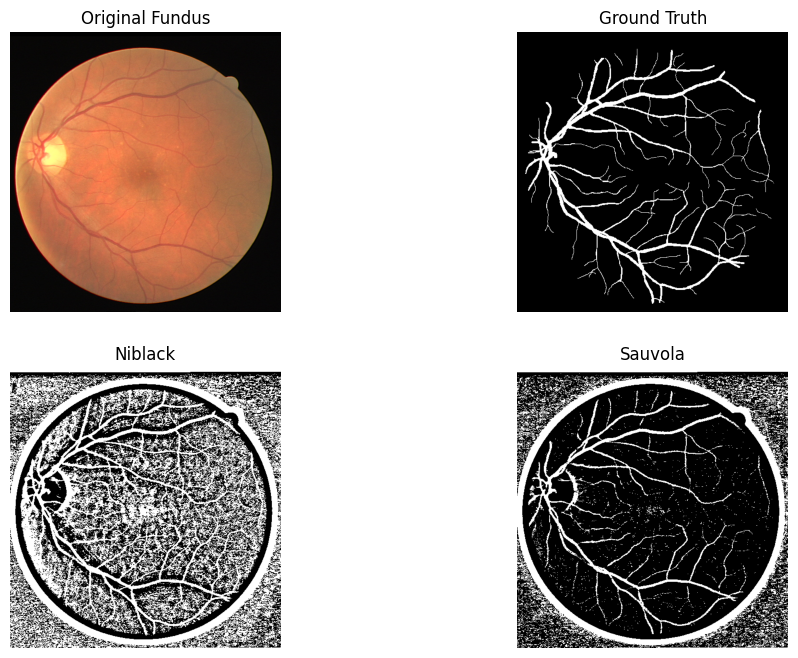

In [ ]:
import matplotlib.pyplot as plt

idx = 0  # choose any 0–19

img = io.imread(img_paths[idx])
gt = io.imread(gt_paths[idx])
gt = np.squeeze(gt)          # fix shape (1,H,W) → (H,W)
gt = (gt > 0).astype(np.uint8)
gt  = (gt > 0).astype(np.uint8)

green = preprocess_green(img)
niblack = segment_niblack(green)
sauvola = segment_sauvola(green)

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.imshow(img)
plt.title("Original Fundus")
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(gt, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(2,2,3)
plt.imshow(niblack, cmap="gray")
plt.title("Niblack")
plt.axis("off")

plt.subplot(2,2,4)
plt.imshow(sauvola, cmap="gray")
plt.title("Sauvola")
plt.axis("off")

plt.show()


In [ ]:
print("GT shape example:", gt.shape)
print("Niblack shape:", niblack.shape)
print("Sauvola shape:", sauvola.shape)


GT shape example: (584, 565)
Niblack shape: (584, 565)
Sauvola shape: (584, 565)


# **Conclusion:**

1) Retinal blood vessels were extracted from DRIVE fundus images using Niblack and Sauvola local adaptive thresholding applied to the green channel, which provides the best vessel contrast. The segmentation results were compared with the manual vessel annotations to evaluate how well each method detects vessel pixels.

2) The quantitative results showed that Niblack achieved higher sensitivity (0.878) than Sauvola (0.667), meaning Niblack was able to detect more thin and low-contrast vessels present in the ground truth. However, visual observation revealed that Niblack also introduces considerable background noise, while Sauvola produces a cleaner and smoother vessel map but misses some very fine branches.

3) This experiment demonstrates that local thresholding methods behave differently on thin retinal structures. Niblack is more sensitive but less selective, whereas Sauvola is more conservative and visually cleaner.
